In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

In [18]:

class NutritionPredictor1(nn.Module):
    def __init__(self, num_outputs):
        super(NutritionPredictor, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        #self.feature_extractor[0][0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

        self.classifier = nn.Sequential(

            nn.BatchNorm1d(125440),
            nn.Linear(125440, 4000),
            nn.ReLU(),
            nn.Linear(4000, 4000),
            nn.ReLU(),
            nn.Linear(4000, num_outputs)
        )
        
    def forward(self, x):
        x1 = x[:,0,:,:]
        x2 = x[:,1,:,:]
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        #y2 = self.feature_extractor(x[1])
        x = torch.cat((x1.view(x1.size(0), -1), x2.view(x2.size(0), -1)), dim=-1)
        x = self.classifier(x)
        return x


class NutritionPredictor(nn.Module):
    def __init__(self, num_outputs):
        super(NutritionPredictor, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        #self.feature_extractor[0][0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

        self.classifier = nn.Sequential(

            nn.BatchNorm1d(125440),
            nn.Linear(125440, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
    def forward(self, x):
        x1 = x[:,0,:,:]
        x2 = x[:,1,:,:]
        x1 = self.feature_extractor(x1)
        x2 = self.feature_extractor(x2)
        #y2 = self.feature_extractor(x[1])
        x = torch.cat((x1.view(x1.size(0), -1), x2.view(x2.size(0), -1)), dim=-1)
        x = self.classifier(x)
        return x

# Example usage
model = NutritionPredictor(num_outputs=5)  # Define num_outputs based on your nutrition scores
for param in model.feature_extractor.parameters():
    param.requires_grad = False


/home/julius/Hack/FoodApp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/julius/Hack/FoodApp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.from_numpy(data).transpose(2,-1).float()
        self.targets = torch.from_numpy(targets).float()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [4]:
model= NutritionPredictor(5)

In [5]:
x1 = torch.rand(5,2,3, 224, 224)
x2 = torch.rand(5,3, 224, 224)   # Example data
y = torch.rand(10, 5)  # Example targets
model(x1).shape

torch.Size([5, 5])

In [6]:
import pandas as pd
import numpy as np
data = np.array(pd.read_pickle('df.pkl'))
depths = pd.read_pickle('depths.pkl')
images = pd.read_pickle('images.pkl')

In [7]:
#X = np.array([np.concatenate([images[i], depths[i]], axis = -1) for i in range(len(images))])
X = np.concatenate([images[:,None], depths[:,None]], axis = 1)
X.shape
del images, depths

In [8]:
y = data[:, 1:6].astype(np.float32)
del data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = scaler.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [10]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(-90, 90))
])

In [11]:
train_dataset = CustomDataset(data=X_train,targets=y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

In [12]:
#im,_= train_dataset[40][0][0]
#im[0].shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


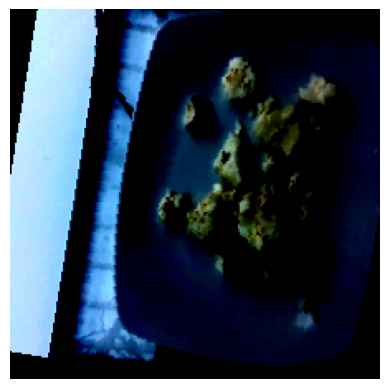

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


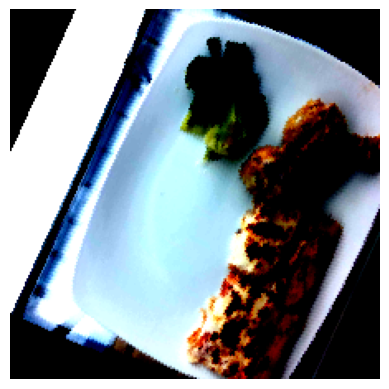

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


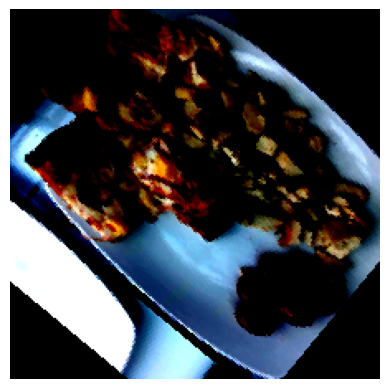

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


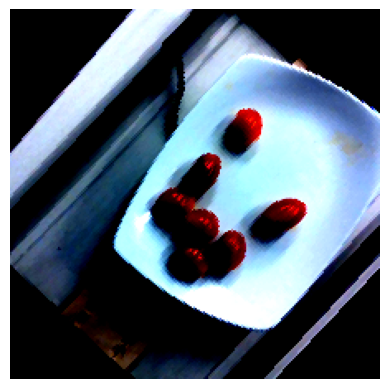

In [13]:
import matplotlib.pyplot as plt
for i in [100, 400,600, 1500]:
    plt.imshow(train_dataset[i][0][0].transpose(0,2))
    plt.axis('off')
    plt.show()


In [14]:
train_dataset.data.shape

torch.Size([2934, 2, 3, 224, 224])

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [16]:
from torch.utils.tensorboard import SummaryWriter
import os

# Initialize the SummaryWriter
# Specify the directory path
directory = 'runs'

# Get the list of files in the directory
file_list = os.listdir(directory)

# Get the number of files
num_files = len(file_list)

# Print the number of files
print(f"Number of files in '{directory}': {num_files}")

writer = SummaryWriter(f'runs/{num_files}')

2024-03-21 20:57:18.256747: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 20:57:18.297472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 20:57:19.149492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of files in 'runs': 16


In [17]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the number of epochs
num_epochs = 50
model = model.to('cuda')
# Training loop
min_val_loss = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_dataloader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        outputs = model(inputs)
        
        # Compute the loss
        loss = loss_fn(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item() * inputs.size(0)
    
    # Compute the average training loss for the epoch
    train_loss /= len(train_dataset)
    writer.add_scalar('training loss', train_loss, epoch)
    # Validation phase
    val_loss = 0.0
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            # Forward pass
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_fn(outputs, targets)
            
            # Accumulate the validation loss
            val_loss += loss.item() * inputs.size(0)
    
    # Compute the average validation loss for the epoch
    val_loss /= len(val_dataset)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'model_rotation_small_dropout.pth')
    writer.add_scalar('validation loss', val_loss, epoch)
    # Print the training and validation loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")


100%|██████████| 92/92 [00:46<00:00,  1.96it/s]


Epoch 1/50 - Train Loss: 0.8141 - Val Loss: 0.9676


100%|██████████| 92/92 [00:45<00:00,  2.03it/s]


Epoch 2/50 - Train Loss: 0.6563 - Val Loss: 0.6854


100%|██████████| 92/92 [00:42<00:00,  2.16it/s]


Epoch 3/50 - Train Loss: 0.6259 - Val Loss: 0.6601


 17%|█▋        | 16/92 [00:07<00:37,  2.02it/s]


KeyboardInterrupt: 

In [19]:
min_val_loss

0.43572567371417986

In [21]:
# Store the state dictionary of the model
torch.save(model.state_dict(), 'model_bn.pth')


In [1]:
model.load_state_dict('model_bn.pth')

NameError: name 'model' is not defined

In [26]:
pred = model(val_dataset.data[10][None].to('cuda')).cpu().detach().numpy()

In [27]:
val_dataset.targets[10], pred

(tensor([0.6738, 0.3345, 0.8961, 0.3513, 0.0302]),
 array([[ 0.00558907, -0.00021567, -0.00154209,  0.00584662, -0.00035114]],
       dtype=float32))